# Augmented PyTorch RGB CNN

In this notebook, we train the same CNN architecture from notebook 03 on the CIFAR-10 dataset with data augmentation for improved generalization.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Package imports
from cifar10_tools.pytorch.evaluation import evaluate_model
from cifar10_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves
)
from cifar10_tools.pytorch.training import train_model

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [2]:
batch_size = 2048
learning_rate = 1e-3
epochs = 100
print_every = 10 # Print training progress every n epochs

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

## 1. Load and preprocess CIFAR-10 data with augmentation

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes. We use RGB images with data augmentation to improve model generalization.

### 1.1. Define transforms

In [3]:
# Training transform with augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Validation/test transform (no augmentation)
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print('Training augmentations:')
print('  - Random horizontal flip (p=0.5)')
print('  - Random rotation (±15°)')
print('  - Random translation (±10%)')
print('  - Color jitter (brightness, contrast, saturation)')

Training augmentations:
  - Random horizontal flip (p=0.5)
  - Random rotation (±15°)
  - Random translation (±10%)
  - Color jitter (brightness, contrast, saturation)


### 1.2. Load datasets

In [4]:
# Make sure data directory exists
data_dir = Path('../data/pytorch/cifar10')
data_dir.mkdir(parents=True, exist_ok=True)

# Load full training dataset (will split into train/val later)
train_dataset_full = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=train_transform
)

# Load validation set with eval transform (no augmentation)
val_dataset_base = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=False,
    transform=eval_transform
)

# Load test dataset with eval transform
test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=eval_transform
)

# Split into train/val (80/20)
n_train = int(0.8 * len(train_dataset_full))
n_val = len(train_dataset_full) - n_train

# Create index-based subsets
generator = torch.Generator().manual_seed(315)
train_indices, val_indices = random_split(
    range(len(train_dataset_full)), 
    [n_train, n_val],
    generator=generator
)

# Create subset datasets
train_dataset = torch.utils.data.Subset(train_dataset_full, train_indices.indices)
val_dataset = torch.utils.data.Subset(val_dataset_base, val_indices.indices)

print(f'Training samples: {len(train_dataset)} (with augmentation)')
print(f'Validation samples: {len(val_dataset)} (no augmentation)')
print(f'Test samples: {len(test_dataset)} (no augmentation)')
print(f'Image shape: {train_dataset_full[0][0].shape}')
print(f'Number of classes: {len(class_names)}')

Training samples: 40000 (with augmentation)
Validation samples: 10000 (no augmentation)
Test samples: 10000 (no augmentation)
Image shape: torch.Size([3, 32, 32])
Number of classes: 10


### 1.3. Visualize sample images (with augmentation)

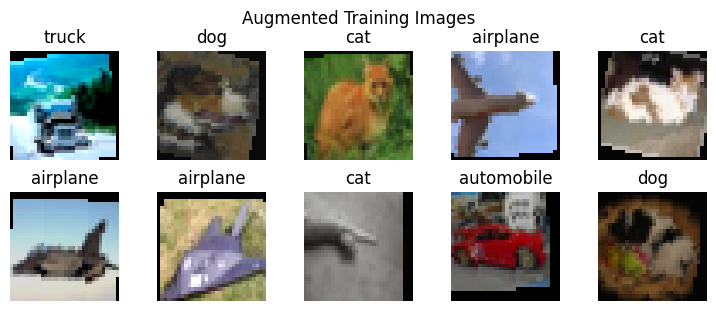

In [5]:
# Plot first 10 images from the training dataset (augmented)
fig, axes = plot_sample_images(train_dataset, class_names, nrows=2, ncols=5)
fig.suptitle('Augmented Training Images', y=1.02)
plt.show()

### 1.4. Create `DataLoader()` objects

In [6]:
# Create DataLoaders (data stays on CPU, moved to GPU per-batch)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True  # Faster CPU->GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')
print(f'\nNote: Data transferred to GPU per-batch for augmentation support')

Training batches: 20
Validation batches: 5
Test batches: 5

Note: Data transferred to GPU per-batch for augmentation support


## 2. Build CNN classifier with nn.Sequential

We build the same CNN architecture as notebook 03, using convolutional layers to extract spatial features from the 32x32x3 RGB images before classification.

### 2.1. Define model architecture

In [7]:
# Input: 3 x 32 x 32 (RGB)
num_classes = 10

model = nn.Sequential(

    # Conv block 1: 3 -> 32 channels, 32x32 -> 16x16
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Conv block 2: 32 -> 64 channels, 16x16 -> 8x8
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Conv block 3: 64 -> 128 channels, 8x8 -> 4x4
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Classifier
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes)
).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params:,}')

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.5, inplace=False)
  (16): Conv2d(64, 128, kernel_size=(3, 3), strid

### 2.2. Define loss function and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 2.3. Train model

In [9]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    print_every=print_every,
    device=device  # Enable per-batch GPU transfer
)

Epoch 1/100 - loss: 2.2011 - accuracy: 16.17% - val_loss: 2.8293 - val_accuracy: 10.01%
Epoch 10/100 - loss: 1.3525 - accuracy: 51.31% - val_loss: 1.1460 - val_accuracy: 58.12%
Epoch 20/100 - loss: 1.1210 - accuracy: 60.74% - val_loss: 0.8845 - val_accuracy: 68.05%
Epoch 30/100 - loss: 1.0000 - accuracy: 65.26% - val_loss: 0.7495 - val_accuracy: 73.43%
Epoch 40/100 - loss: 0.9159 - accuracy: 68.74% - val_loss: 0.6837 - val_accuracy: 75.66%
Epoch 50/100 - loss: 0.8602 - accuracy: 70.84% - val_loss: 0.7538 - val_accuracy: 74.21%
Epoch 60/100 - loss: 0.8161 - accuracy: 72.40% - val_loss: 0.6116 - val_accuracy: 77.98%
Epoch 70/100 - loss: 0.7882 - accuracy: 73.48% - val_loss: 0.6045 - val_accuracy: 78.27%
Epoch 80/100 - loss: 0.7562 - accuracy: 74.66% - val_loss: 0.5643 - val_accuracy: 80.27%
Epoch 90/100 - loss: 0.7303 - accuracy: 75.22% - val_loss: 0.5391 - val_accuracy: 80.64%
Epoch 100/100 - loss: 0.7162 - accuracy: 76.15% - val_loss: 0.5176 - val_accuracy: 81.35%

Training complete.
C

### 2.4. Learning curves

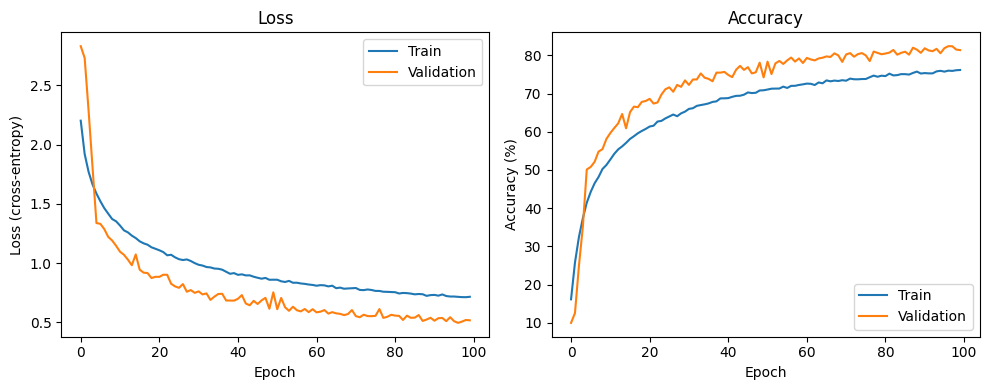

In [10]:
fig, axes = plot_learning_curves(history)
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [11]:
# Custom evaluation with per-batch GPU transfer
model.eval()
predictions = []
true_labels = []
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 81.29%


### 3.2. Per-class accuracy

In [12]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 81.30%
automobile  : 94.10%
bird        : 65.40%
cat         : 61.50%
deer        : 68.20%
dog         : 78.10%
frog        : 90.80%
horse       : 87.90%
ship        : 94.00%
truck       : 91.60%


### 3.3. Confusion matrix

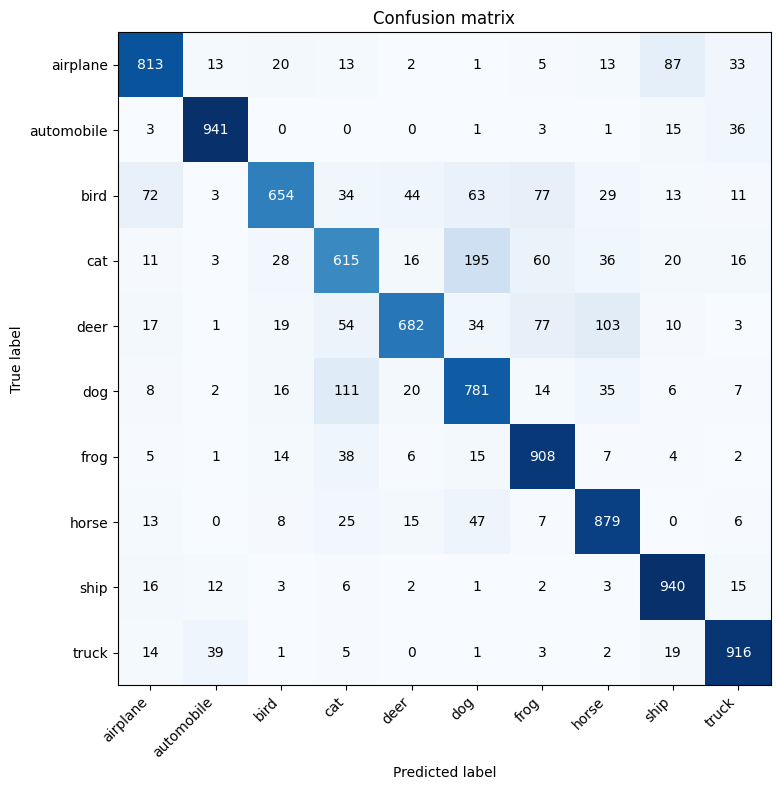

In [13]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 3.4. Predicted class probability distributions

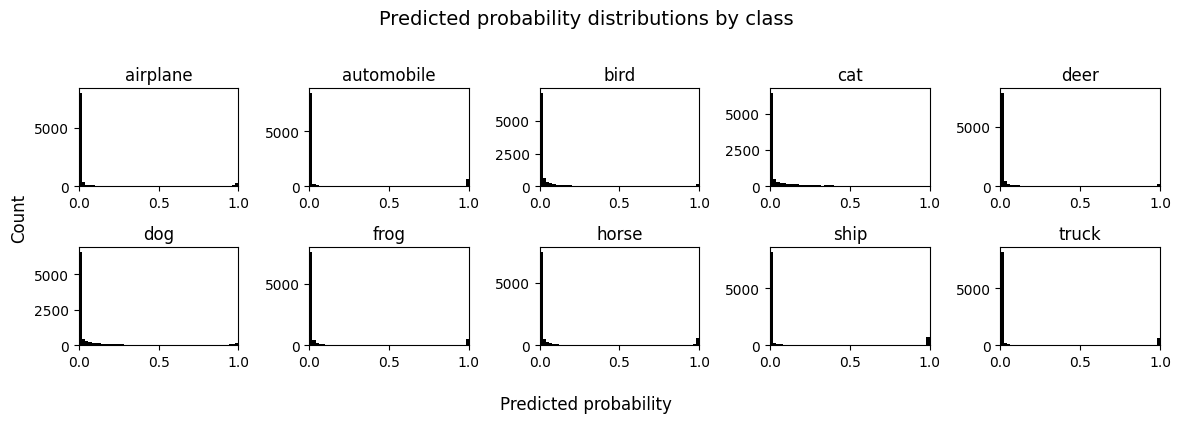

In [14]:
# Get predicted probabilities for all test samples
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 3.5. Evaluation curves

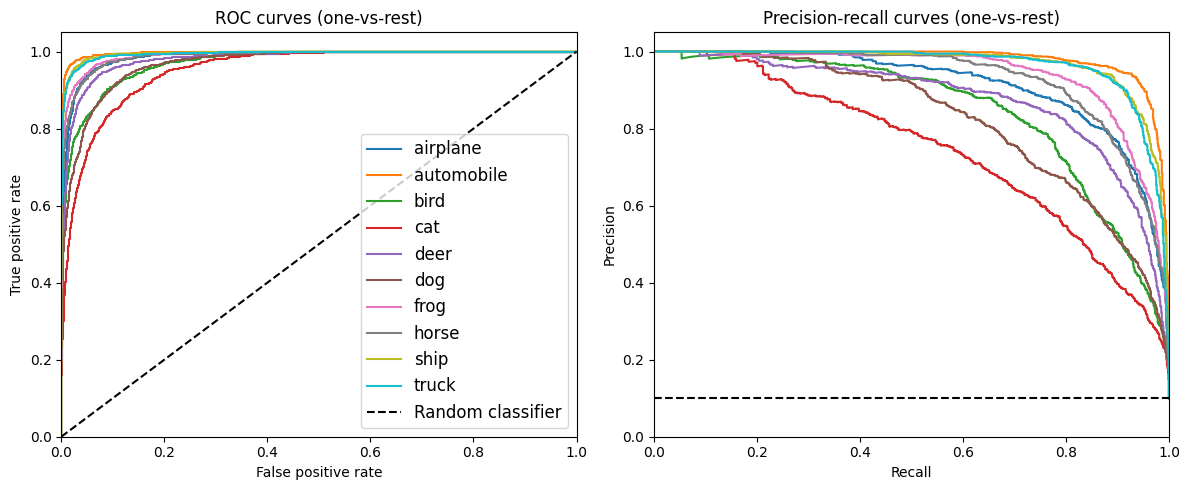

In [15]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 4. Save model

In [16]:
# Create models directory if it doesn't exist
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'augmented_cnn.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/augmented_cnn.pth
Test accuracy: 81.29%
